In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime


import jenkspy

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### Binarization Step Parameters ###
bin_method = "Jenks" # binarization method should be "GMM" or "Jenks"
snr_pval = 0.01
min_n_samples = -1 # define authomatically if -1

### Feature clustering parameters ###
min_SNR = 0.5
clust_method = "WGCNA" # feature clustering method "WGCNA" or "DESMOND"

if clust_method == "WGCNA":
    p1 = 10 # power for correlation matrix [1-30]
    p2 = 10 # power for tree cutof height 
    
if clust_method == "DESMOND":
    # PGM parameters
    alpha = 10.0 
    beta_K = 1.0

    # convergence
    max_n_steps= 50
    n_steps_for_convergence = 10

# seed - makes sense only for GMM and DESMOND - TBD
seed = 42


### input and output  ###

verbose = True
plot_all = True

# whether to load and to save binarized data
load = False
save = True

out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-BRCA"

data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv" # z-normalized expressions

In [3]:
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of samples
if min_n_samples == -1:
    min_n_samples = int(max(20,0.01*exprs.shape[1])) # set to max(20, 1% of the cohort) 
if verbose:
    print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)

Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA*
Mininal number of samples in a bicluster: 20


# 1) Binarize individual features

### Find the trend between SNR and bicluster size

1) for all sizes [min_n_samples, int(N/2)+ min_n_samples], generate splits of random samples drawn from normal distributions

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.01; get_snr_thr is a function of bicluser size 


### Binarize expressions:

 * Jenks or GMM binarization
 * filtering by sample nubmer and SNR
     - n_samples =< min_n_samples, and
     - SNR > SNR_thr(n_samples)


Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945, min_n_samples: 20 - 492, n_permutations: 500


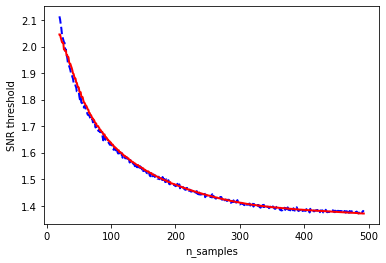

	SNR thresholds for individual features computed in 27.14 seconds
	Jenks method is chosen ...
		genes processed: 0
Gene APOBEC3A: SNR=1.38, pos=386, neg=559


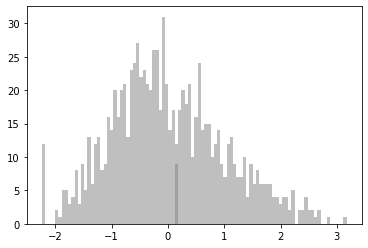

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
Gene ERBB2: SNR=2.05, pos=104, neg=841


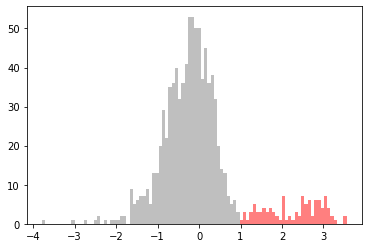

Gene ESR1: SNR=2.22, pos=713, neg=232


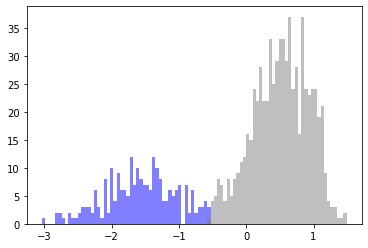

Gene FOXA1: SNR=2.62, pos=790, neg=155


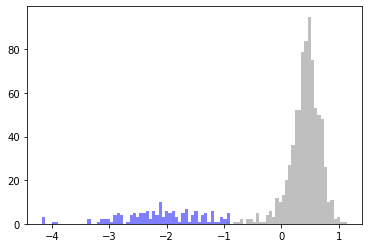

		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
Gene PIK3R2: SNR=5.18, pos=487, neg=458


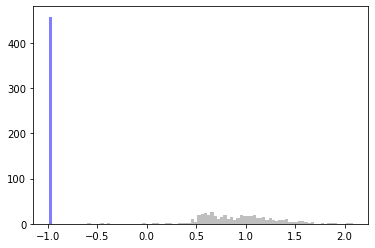

		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	Jenks binarization for 14986 features completed in 28.88 s
		up-regulated features: 526
		down-regulated features: 1830
		ambiguous features: 67
	binarization runtime: 56.02 s
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.Jenks.binarized_UP.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.Jenks.binarized_DOWN.tsv


In [4]:
from method import binarize

show_fits = [ "FOXA1","ESR1","ERBB2",'APOBEC3A',"PIK3R2"] # some exmaple genes

if load: 
    binarized_data = out_dir+"/"+basename
else: 
    binarized_data = None
    
binarized_expressions = binarize(exprs,binarized_fname_prefix = binarized_data,
                                 method=bin_method, save = save, prefix = out_dir+"/"+basename,
                                 min_n_samples = min_n_samples, snr_pval = snr_pval,
                                 plot_all = plot_all,show_fits =show_fits,
                                 verbose= verbose,seed=seed)

    

# Step 2. Group features into modules

Input: binarized expressions
Output: modules - sets of features with the same 1/0 profiles

 - feature clustering: choose WGCNA or DESMOND 
 - runs for up- and down-regulated features separately
 



##    WGCNA:

In [9]:
if clust_method == "WGCNA":
    from method import run_WGCNA
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
        clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)

Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.Jenks.binarized_UP.tsv ...
	WGCNA runtime: modules detected in 8.67 s.
	35 modules and 98 not clustered genes
Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.Jenks.binarized_DOWN.tsv ...
	WGCNA runtime: modules detected in 11.48 s.
	46 modules and 618 not clustered genes


## DESMOND:

time:	Initial state created in 1.5 s.
		LP memory, 2.11 M
		step  1 1.7 s
		step  2 1.0 s
		step  3 0.7 s
		step  4 0.5 s
		step  5 0.5 s
		step  6 0.6 s
		step  7 0.6 s
		step  8 0.6 s
		step  9 0.5 s
		step  10 0.5 s
		step  11 0.5 s
			features oscilating in the last 10 steps: 109
		step  12 0.6 s
			features oscilating in the last 10 steps: 39
		step  13 0.5 s
			features oscilating in the last 10 steps: 26
		step  14 0.6 s
			features oscilating in the last 10 steps: 22
		step  15 0.6 s
			features oscilating in the last 10 steps: 19
		step  16 0.6 s
			features oscilating in the last 10 steps: 19
		step  17 0.6 s
			features oscilating in the last 10 steps: 22
		step  18 0.6 s
			features oscilating in the last 10 steps: 22
		step  19 0.5 s
			features oscilating in the last 10 steps: 25
		step  20 0.6 s
			features oscilating in the last 10 steps: 23
			convergence condition: False ; curve slope: -0.11
		step  21 0.6 s
			features oscilating in the last 10 steps: 23
			convergen

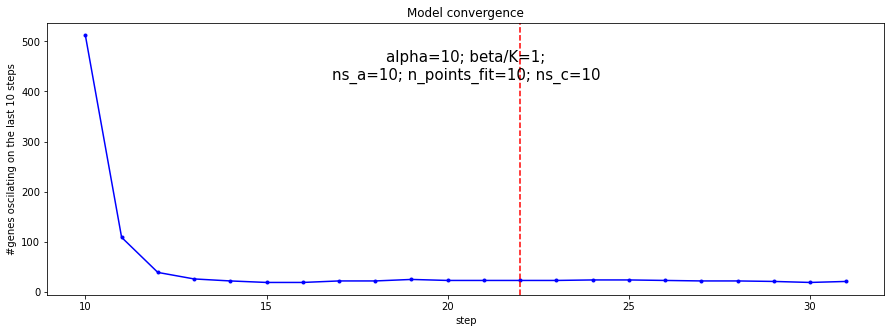

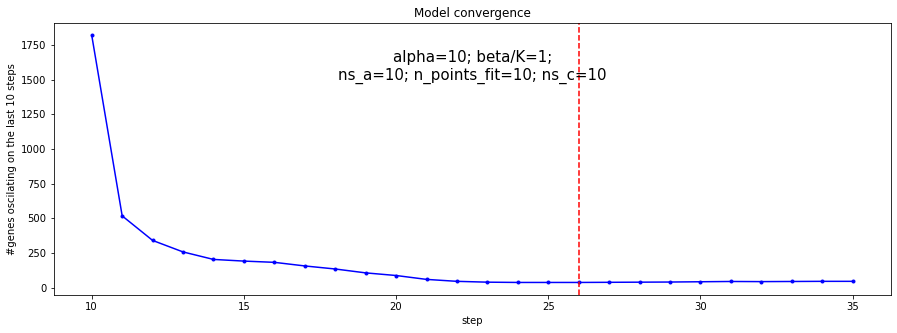

In [11]:
clust_method = "DESMOND"
if clust_method == "DESMOND":
    from pgm import run_sampling
    # PGM parameters
    alpha = 10 # convergence fails from 0.25; 0.33 is still Ok
    beta_K = 1

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10

    clustering_results ={}
    for d in ["UP","DOWN"]:
        exprs_bin = binarized_expressions[d]
        genes = exprs_bin.columns.values
        clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                    max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                    n_points_fit = n_points_fit, tol = 0.1,
                    n_steps_for_convergence = n_steps_for_convergence,
                    verbose =verbose,plot_all=plot_all)

# 3. Split each module to bicluster and background

 * Jenks is th only option, GMM makes no sense for small biclusters of 2-3-5 genes 
 * based on 1/0 profile
 * if min_SNR is set, remove genes not matching with the rest of bicluster

In [13]:
from method import modules2biclsuters_jenks

biclusters, not_clustered = modules2biclsuters_jenks(clustering_results,exprs,binarized_expressions,
                                                     min_SNR = min_SNR,min_n_samples=min_n_samples,
                                                     snr_pval=snr_pval,
                                                     bin_method = bin_method, clust_method = clust_method,
                                                     result_file_name = out_dir+basename,
                                                     directions=["UP","DOWN"],
                                                     plot=False,verbose = False)

UP : 286 features clustered into 33 modules, 403 - not clustered.
DOWN : 461 features clustered into 32 modules, 2641 - not clustered.


# All steps in one function

* Input:  expression matrix (genes x samples); z-normalized for between-sample comparison 
* Can start from binarized data if binarized = "binarized_data_file_prefix", e.g. 
  "path/to/results/TCGA" for files "TCGA.GMM.binarized_UP.tsv" and "TCGA.GMM.binarized_DOWN.tsv" 
  and bin_mehtod="GMM"
* Output: 
     - biclusters: {"UP":df_biclusters_up, "DOWN":df_biclusters_down}
     - biclusters are also save to files
     - lists of not clustered genes:   {"UP":df_biclusters_up, "DOWN":df_biclusters_down}

In [14]:
def run_DESMOND(exprs_file, out_dir="",basename="",  
                binarized_data = None, save=True,
                bin_method = "GMM", clust_method = "WGCNA", 
                min_n_samples = -1,snr_pval = 0.01, min_SNR = 0.5,
                p1=10,p2=10,alpha=10,beta_K = 1,
                max_n_steps= 50, n_steps_for_convergence = 10,
                verbose = True, plot_all = False):
    
    start_time = time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 
        
    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)
    if verbose:
        print("Read input from:",exprs_file ,file=sys.stdout)
        print("\t{} features x {} samples".format(exprs.shape[0],exprs.shape[1]) ,file=sys.stdout)

    # define minimal number of samples
    if min_n_samples == -1:
        min_n_samples = int(max(20,0.01*exprs.shape[1])) # set to max(20, 1% of the cohort) 
    if verbose:
        print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
        print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
        
    
    # binarization
    from method import binarize
    binarized_expressions = binarize(exprs=exprs, binarized_fname_prefix=binarized_data,
                                     method=bin_method,
                                     save = save, prefix = out_dir+"/"+basename,
                                     min_n_samples = min_n_samples, snr_pval = snr_pval,
                                     plot_all = plot_all,show_fits =show_fits,
                                     verbose= verbose,seed=seed)

    
    # gene clustering 
    if clust_method == "WGCNA":
        from method import run_WGCNA

        clustering_results = {}
        for d in ["UP","DOWN"]:
            fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
            clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)
            
    elif clust_method == "DESMOND":
        from pgm import run_sampling
        
        # convergence
        n_steps_averaged = 10
        n_points_fit=10

        clustering_results ={}
        for d in ["UP","DOWN"]:
            exprs_bin = binarized_expressions[d]
            genes = exprs_bin.columns.values
            clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                        max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                        n_points_fit = n_points_fit, tol = 0.1,
                        n_steps_for_convergence = n_steps_for_convergence,
                        verbose =verbose,plot_all=plot_all)
    else:
        print("'clust_method' must be 'WGCNA' or 'DESMOND'.",file=sys.stderr)
        
    # finiding biclusters 
    from method import modules2biclsuters_jenks

    biclusters, not_clustered = modules2biclsuters_jenks(clustering_results,exprs,binarized_expressions,
                                                         min_SNR = min_SNR,min_n_samples=min_n_samples,
                                                         snr_pval=snr_pval,
                                                         bin_method = bin_method, clust_method = clust_method,
                                                         result_file_name = out_dir+basename,
                                                         directions=["UP","DOWN"],
                                                         plot=False,verbose = False)
    
    print("Total runtime: {:.2f} s".format(time()-start_time ),file = sys.stdout)
    
    return biclusters, not_clustered

### Run with GMM binarization and WGCNA clustering

In [15]:
basename = "OV244"
exprs_file = "/home/olya/TUM/DESMOND/DESMOND2/OV_cancer/OV_norm_counts.log2.z.tsv"

biclusters, not_clustered = run_DESMOND(exprs_file, out_dir=out_dir,basename=basename,
                                        bin_method="GMM",clust_method="WGCNA")

Read input from: /home/olya/TUM/DESMOND/DESMOND2/OV_cancer/OV_norm_counts.log2.z.tsv
	17198 features x 244 samples
Mininal number of samples in a bicluster: 20
Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/OV244*

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 244, min_n_samples: 20 - 142, n_permutations: 500
	SNR thresholds for individual features computed in 4.06 seconds
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
		genes processed: 15000
		genes processed: 16000
		genes processed: 17000
	GMM binarization for 17198 features completed in 90.08 s
	up-regulated features: 630
	down-r

### Once again from binarized data with different clust_method

In [16]:
biclusters2, not_clustered2 = run_DESMOND(exprs_file,binarized_data = out_dir+basename, 
            out_dir=out_dir,basename=basename,
            bin_method="GMM",clust_method="DESMOND")

Read input from: /home/olya/TUM/DESMOND/DESMOND2/OV_cancer/OV_norm_counts.log2.z.tsv
	17198 features x 244 samples
Mininal number of samples in a bicluster: 20
Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/OV244*
Load binarized features from /home/olya/TUM/DESMOND/DESMOND2/tmp_results/OV244.GMM.binarized_UP.tsv
Load binarized features from /home/olya/TUM/DESMOND/DESMOND2/tmp_results/OV244.GMM.binarized_DOWN.tsv

time:	Initial state created in 0.4 s.
		LP memory, 3.03 M
		step  1 2.3 s
		step  2 1.6 s
		step  3 1.3 s
		step  4 1.5 s
		step  5 1.4 s
		step  6 1.6 s
		step  7 1.2 s
		step  8 1.1 s
		step  9 1.2 s
		step  10 1.3 s
		step  11 1.1 s
			features oscilating in the last 10 steps: 215
		step  12 1.0 s
			features oscilating in the last 10 steps: 166
		step  13 1.0 s
			features oscilating in the last 10 steps: 145
		step  14 1.0 s
			features oscilating in the last 10 steps: 129
		step  15 1.0 s
			features oscilating in the last 10 steps: 117
		step  16 1.1 